In [1]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
from IPython.display import display_html
from itertools import chain, cycle
import seaborn as sns
import matplotlib.pyplot as plt

from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, f1_score
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import set_config
set_config(display="diagram")

import warnings
warnings.filterwarnings('ignore')

## Project Context

- data: dataset from bank customers for one year
- main goal: be able to predict if cusomer accepts credit card service offer or not
- problem type: binary classification for positive and negative class ('YES' or 'NO' to credit card offer)

## Project Setup

In [2]:
columns=['Customer Number', 'Offer Accepted', 'Reward', 'Mailer Type', 'Income Level','Bank Accounts Open', \
         'Overdraft Protection', 'Credit Rating','Credit Cards Held', 'Homes Owned', 'Household Size', \
         'Own Your Home', 'Average Balance', 'Q1 Balance', 'Q2 Balance',  'Q3 Balance', 'Q4 Balance']

In [3]:
df_init = pd.read_csv('./files/creditcardmarketing.csv', names=columns)
df_init.head(3)

,Customer Number,Offer Accepted,Reward,Mailer Type,Income Level,Bank Accounts Open,Overdraft Protection,Credit Rating,Credit Cards Held,Homes Owned,Household Size,Own Your Home,Average Balance,Q1 Balance,Q2 Balance,Q3 Balance,Q4 Balance
0,1,No,Air Miles,Letter,High,1,No,High,2,1,4,No,1160.75,1669.0,877.0,1095.0,1002.0
1,2,No,Air Miles,Letter,Medium,1,No,Medium,2,2,5,Yes,147.25,39.0,106.0,78.0,366.0
2,3,No,Air Miles,Postcard,High,2,No,Medium,2,1,2,Yes,276.50,367.0,352.0,145.0,242.0


### Basic Data Cleaning & NaN check

In [4]:
# custom class for initial data cleaning
class CustomInitialDataCleaner:
    def __init__(self):
        pass
    
    def __remove_duplicates(self, X):
        return X[~X.duplicated()]
    
    def __standardize_feature_headers(self, X):
        X.columns = [col.lower().replace(' ', '_') for col in X.columns]
        return X
        
    def clean(self, X):
        X = self.__remove_duplicates(X)
        return self.__standardize_feature_headers(X)

In [5]:
cleaner = CustomInitialDataCleaner()
df = cleaner.clean(df_init)
# set index to customer number
df.set_index('customer_number', inplace=True)
df.head(3)

,offer_accepted,reward,mailer_type,income_level,bank_accounts_open,overdraft_protection,credit_rating,credit_cards_held,homes_owned,household_size,own_your_home,average_balance,q1_balance,q2_balance,q3_balance,q4_balance
customer_number,,,,,,,,,,,,,,,,
1,No,Air Miles,Letter,High,1,No,High,2,1,4,No,1160.75,1669.0,877.0,1095.0,1002.0
2,No,Air Miles,Letter,Medium,1,No,Medium,2,2,5,Yes,147.25,39.0,106.0,78.0,366.0
3,No,Air Miles,Postcard,High,2,No,Medium,2,1,2,Yes,276.50,367.0,352.0,145.0,242.0


In [6]:
df_nans = df[df.isna().any(axis=1)]
yes = df_nans[df_nans['offer_accepted'] == 'Yes'].shape
no = df_nans[df_nans['offer_accepted'] == 'No'].shape

print(f'total rows with nan values: {df_nans.shape[0]}')
print(f'from nan rows, how many with offer accepted YES: ', yes[0])
print(f'from nan rows, how many with offer accepted NO: ', no[0])

total rows with nan values: 24
from nan rows, how many with offer accepted YES:  2
from nan rows, how many with offer accepted NO:  22


- since nan values in very few rows - drop the nans completely

In [7]:
df.dropna(inplace=True)
df.isna().sum()

offer_accepted          0
reward                  0
mailer_type             0
income_level            0
bank_accounts_open      0
overdraft_protection    0
credit_rating           0
credit_cards_held       0
homes_owned             0
household_size          0
own_your_home           0
average_balance         0
q1_balance              0
q2_balance              0
q3_balance              0
q4_balance              0
dtype: int64

## EDA

### First Look

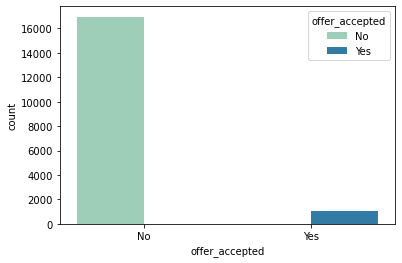

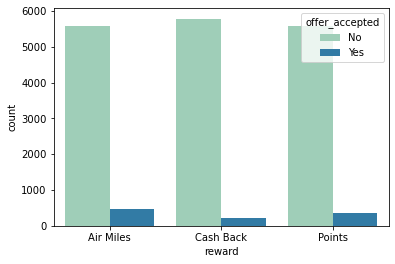

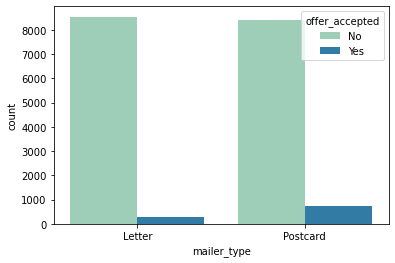

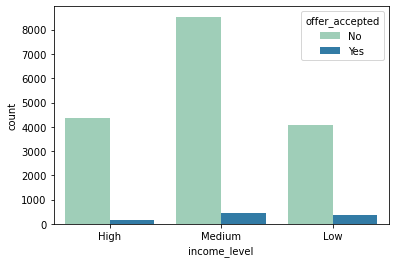

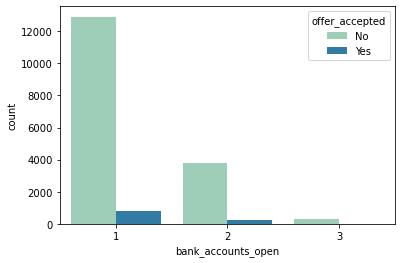

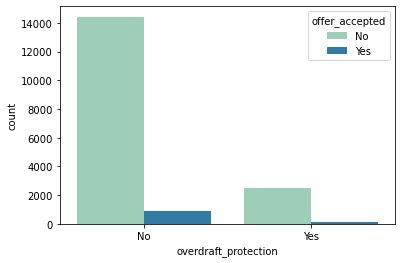

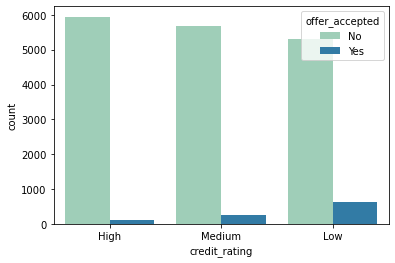

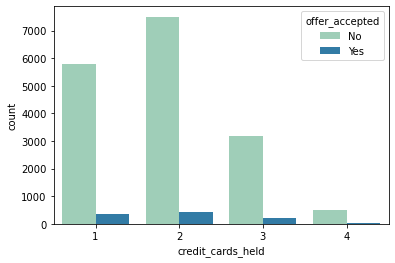

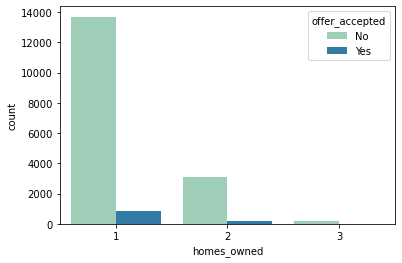

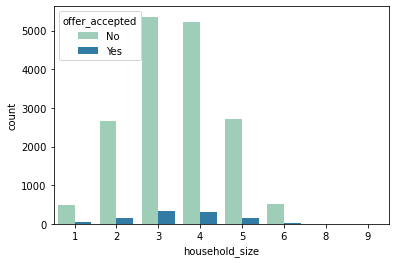

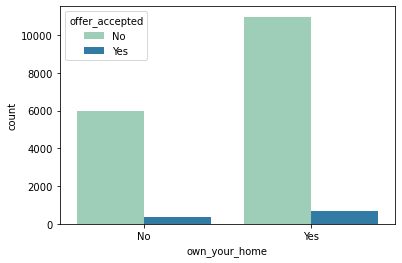

In [8]:
# df_adjusted excludes the numerical features which are not discrete so that we can use countplot for first insights
df_adjusted = df.loc[:, ~df.columns.isin(['q1_balance', 'q2_balance', 'q3_balance', 'q4_balance','average_balance'])]

for col in df_adjusted:
    sns.countplot(col, hue='offer_accepted', data=df, palette='YlGnBu')
    plt.show()

## Check numerical features

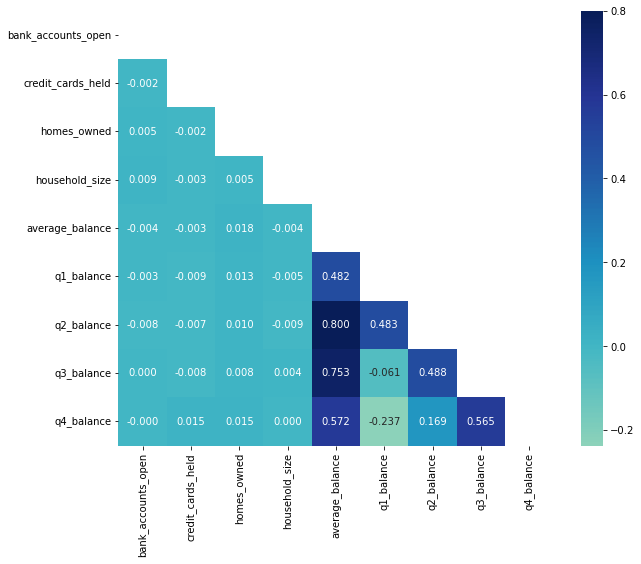

In [9]:
# check for correlation wiht help of correlation matrix:
num_corr = df.select_dtypes('number').corr()
mask = np.zeros_like(num_corr)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(num_corr, center=0, fmt=".3f", square=True, annot=True, mask=mask, cmap="YlGnBu")
plt.show()

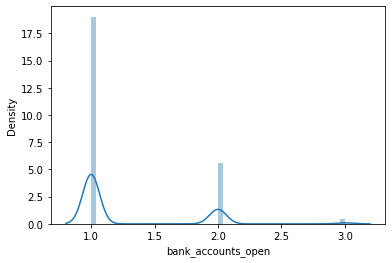

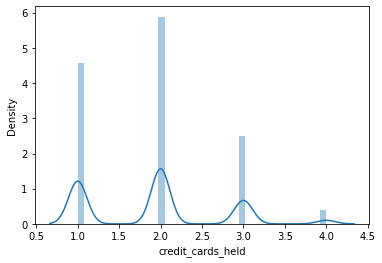

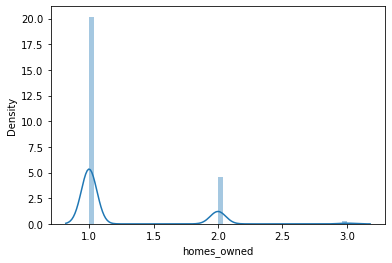

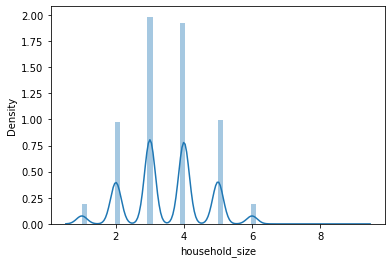

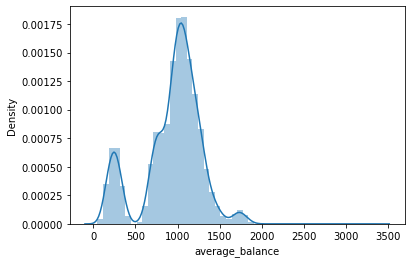

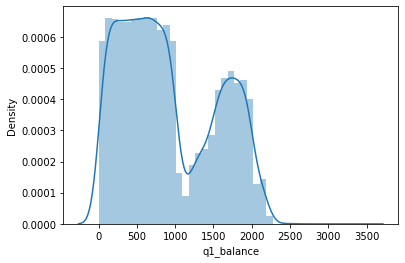

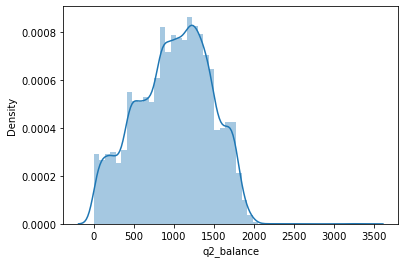

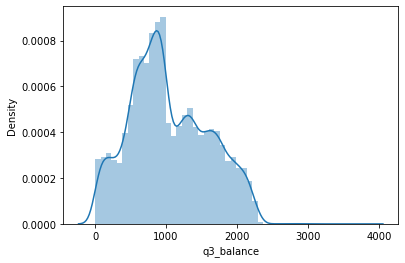

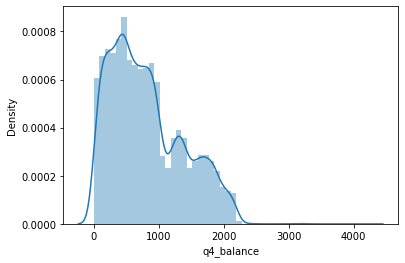

In [10]:
# plot distributions of the numerical features
for col in df.select_dtypes('number'):
    sns.distplot(df[col])
    plt.show()

- features: bank_accounts_open, credit_cards_held, homes_owned and household_size are discrete

### Check categorical features

In [11]:
df.select_dtypes('object').apply(lambda col: col.unique())

offer_accepted                               [No, Yes]
reward                  [Air Miles, Cash Back, Points]
mailer_type                         [Letter, Postcard]
income_level                       [High, Medium, Low]
overdraft_protection                         [No, Yes]
credit_rating                      [High, Medium, Low]
own_your_home                                [No, Yes]
dtype: object

In [12]:
# Checking frequency of data
# There is some imbalance
for col in df.select_dtypes('object').columns:
    print(df[col].value_counts())
    print()

No     16955
Yes     1021
Name: offer_accepted, dtype: int64

Air Miles    6047
Cash Back    5995
Points       5934
Name: reward, dtype: int64

Postcard    9134
Letter      8842
Name: mailer_type, dtype: int64

Medium    9002
High      4519
Low       4455
Name: income_level, dtype: int64

No     15300
Yes     2676
Name: overdraft_protection, dtype: int64

High      6064
Medium    5964
Low       5948
Name: credit_rating, dtype: int64

Yes    11636
No      6340
Name: own_your_home, dtype: int64



In [13]:
df['offer_accepted'].value_counts() / df.shape[0] * 100

No     94.320205
Yes     5.679795
Name: offer_accepted, dtype: float64

In [14]:
# Setting up crosstabs
reward = pd.crosstab(df['reward'], df['offer_accepted'], margins=True)
mailer_type = pd.crosstab(df['mailer_type'], df['offer_accepted'], margins=True)
income_level = pd.crosstab(df['income_level'], df['offer_accepted'], margins=True)
overdraft_protection = pd.crosstab(df['overdraft_protection'], df['offer_accepted'], margins=True)
credit_rating = pd.crosstab(df['credit_rating'], df['offer_accepted'], margins=True)
own_your_home = pd.crosstab(df['own_your_home'], df['offer_accepted'], margins=True)

all_crosstabs = [reward, mailer_type, income_level, overdraft_protection, credit_rating, own_your_home]

In [15]:
for tab in all_crosstabs:
    stat, p, dof, expected = chi2_contingency(tab)
    alpha = 0.05
    if p > alpha:
        print(p)
        print('Variables are independent')
        print()
    else:
        print(p)
        print('Variables are dependent')
        print()

1.4456214412928917e-19
Variables are dependent

1.1105174773164281e-35
Variables are dependent

3.559085897825231e-22
Variables are dependent

0.9979597462857913
Variables are independent

5.6707215130901575e-93
Variables are dependent

0.9999999997513797
Variables are independent



### Check for outliers

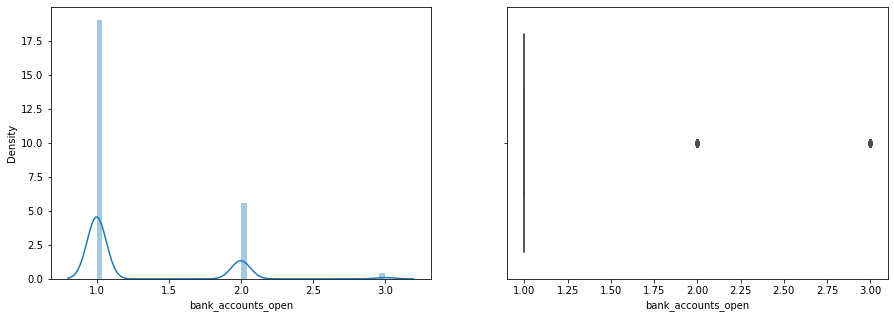

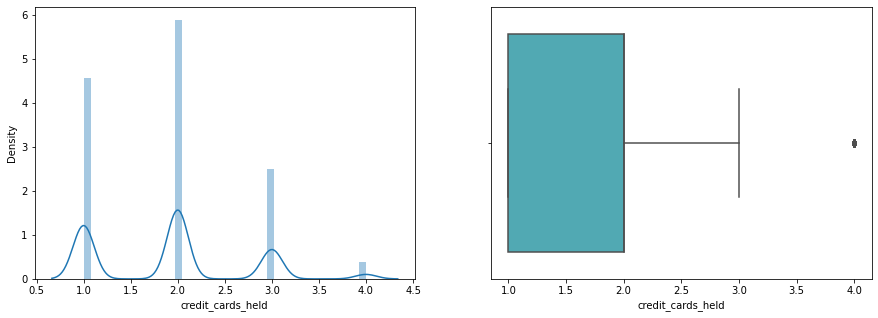

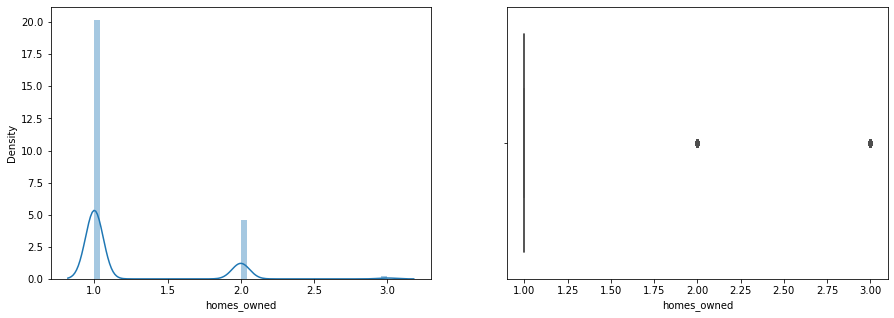

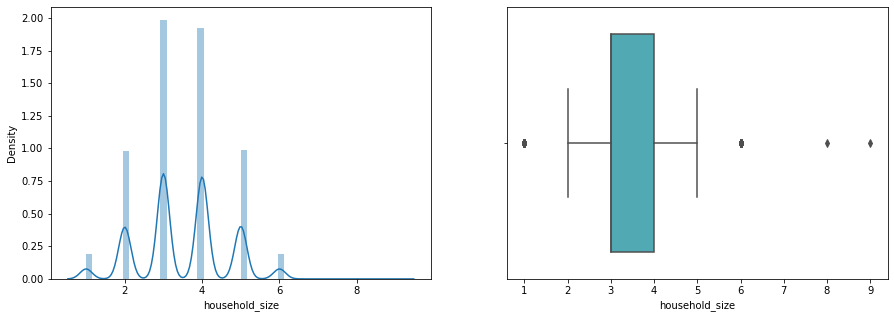

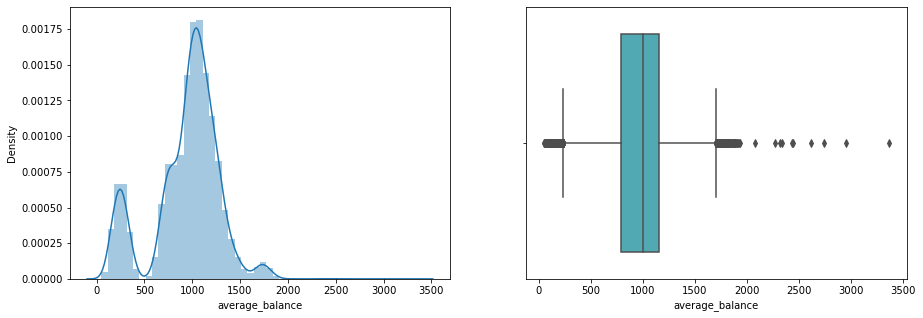

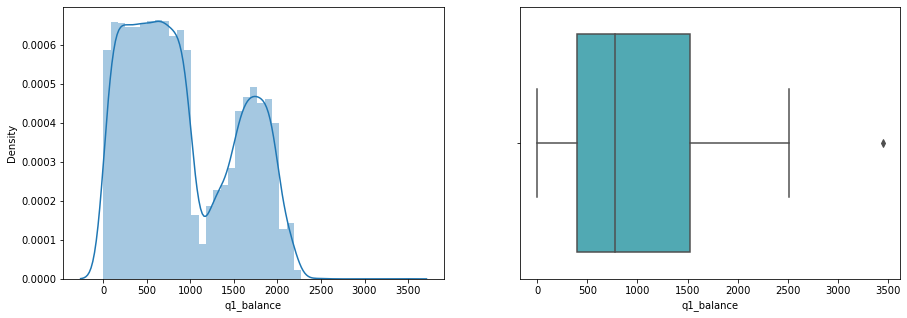

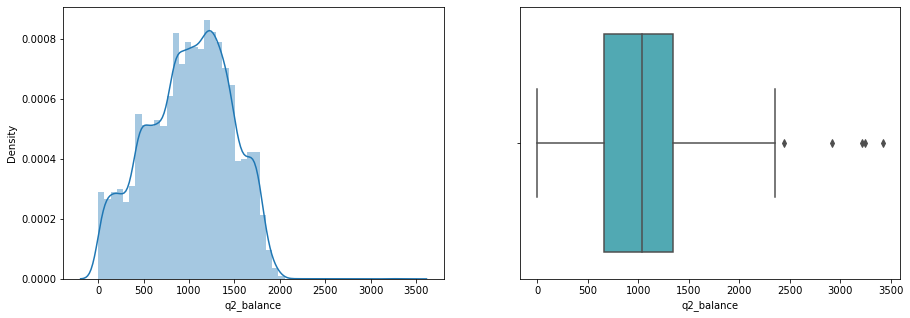

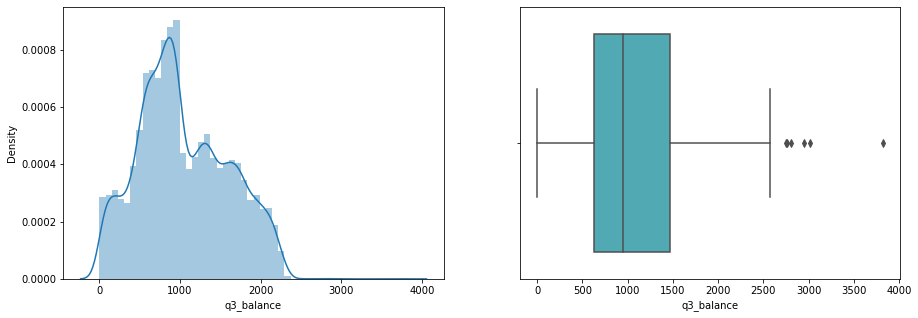

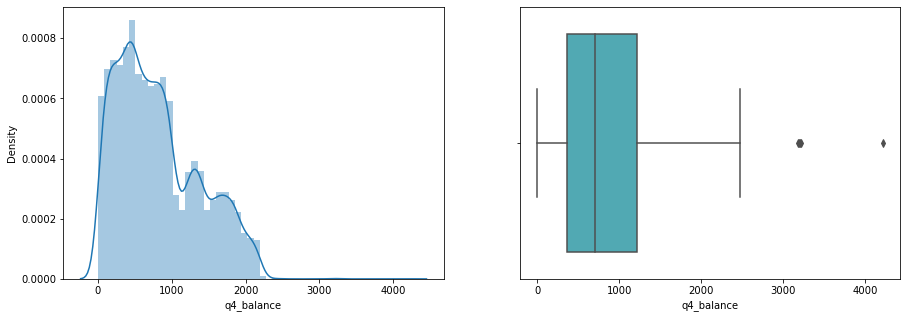

In [16]:
for col in df.select_dtypes('number'):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    
    sns.distplot(df[col], ax=ax[0])

    sns.boxplot(x=df[col], data=df, palette='YlGnBu', ax=ax[1])
    plt.show()
    

In [17]:
# Custom class to deal with outliers
# detects outliers and replaces them with mean value of the respecive feature since we do not want to remove
# any samples if they belong to the positive class (so that the class imbalance should not be made worse)

class CustomOutlierRemover:
    def __init__(self, outlier_threshold, skip_features=[], ):
        self.outlier_threshold = outlier_threshold
        self.skip_features = skip_features
        
    def __outliers_detect(self, X):
        for column in X.select_dtypes(np.number).columns:
            if column not in self.skip_features:
                upper = np.nanpercentile(X[column],75)
                lower = np.nanpercentile(X[column],25)
                iqr = upper - lower
                upper_limit = upper + self.outlier_threshold * iqr
                lower_limit = lower - self.outlier_threshold * iqr if \
                (lower - self.outlier_threshold * iqr) > 0 else 0
                filtered = X[(X[column]>lower_limit) & (X[column]<upper_limit)]
                if filtered.shape[0] != X.shape[0]:
                    self.detected_outliers_.append({
                        'column': column, 
                        'ul_ll': [upper_limit, lower_limit], 
                        'detected_elements': X.shape[0] - filtered.shape[0] 
                    })
                    self.count_total_outliers_ += X.shape[0] - filtered.shape[0]
        
    def __outliers_remove(self, X):
        for outlier in self.detected_outliers_:
            filter_max = X[outlier['column']] > outlier['ul_ll'][0]
            filter_min = X[outlier['column']] < outlier['ul_ll'][1]
            X[outlier['column']].loc[filter_min | filter_max] = X[outlier['column']].mean()
        return X
    
    def clean(self, X):
        X_c = X.copy()
        self.detected_outliers_ = []
        self.count_total_outliers_ = 0
        self.__outliers_detect(X_c)
        X_new = self.__outliers_remove(X_c)
        return X_new

In [18]:
# skip all the discrete numerical features
skip_features = ['household_size', 'bank_accounts_open', 'credit_cards_held', 'homes_owned']
cor = CustomOutlierRemover(outlier_threshold=1.7, skip_features=skip_features)
df_clean = cor.clean(df)

In [19]:
# check info on what outliers were detected:
cor.detected_outliers_

[{'column': 'average_balance',
  'ul_ll': [1775.025, 165.72500000000002],
  'detected_elements': 464},
 {'column': 'q1_balance',
  'ul_ll': [3439.0249999999996, 0],
  'detected_elements': 6},
 {'column': 'q2_balance', 'ul_ll': [2496.3, 0], 'detected_elements': 5},
 {'column': 'q3_balance', 'ul_ll': [2874.0, 0], 'detected_elements': 4},
 {'column': 'q4_balance', 'ul_ll': [2655.3, 0], 'detected_elements': 10}]

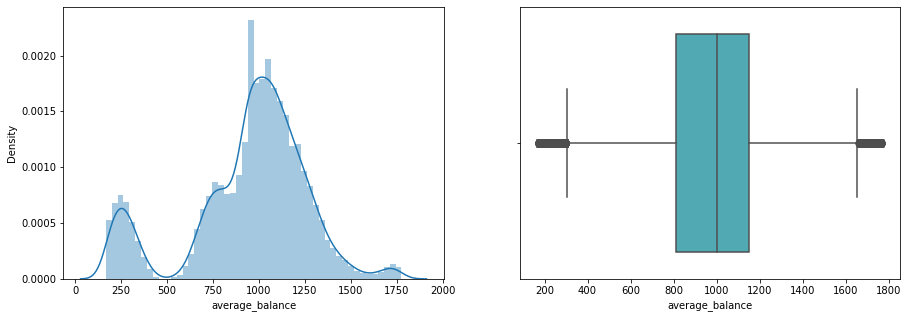

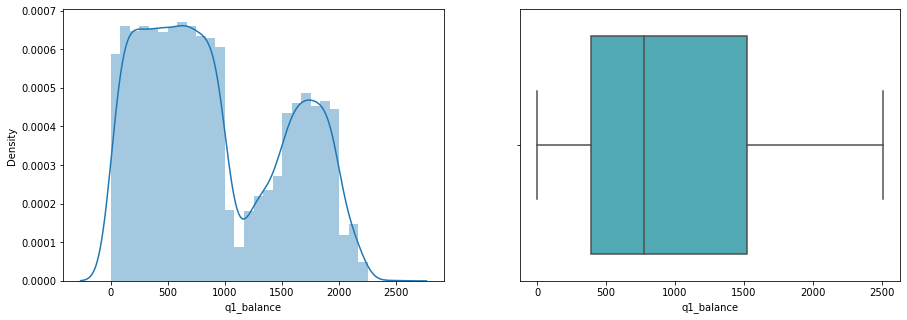

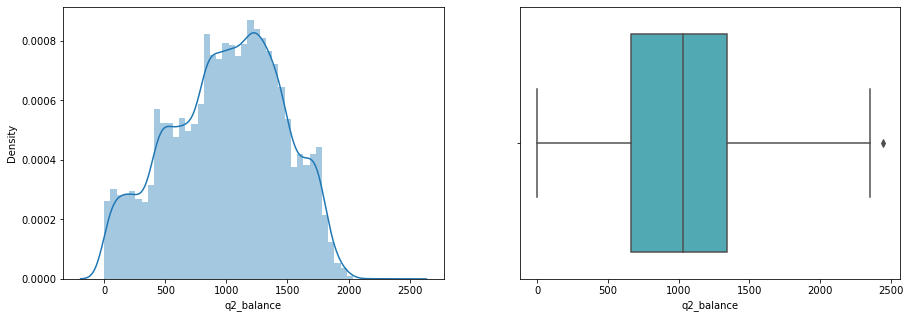

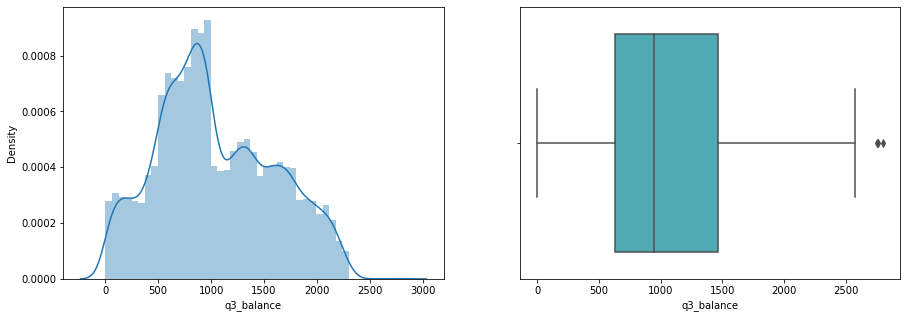

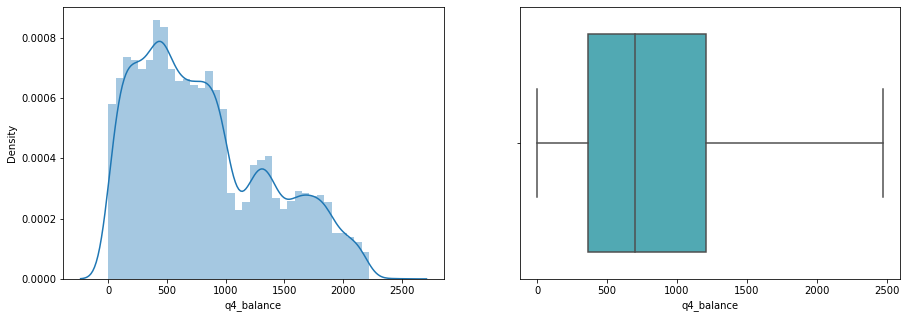

In [20]:
for item in cor.detected_outliers_:
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    
    sns.distplot(df_clean[item['column']], ax=ax[0])

    sns.boxplot(x=df_clean[item['column']], data=df_clean, palette='YlGnBu', ax=ax[1])
    plt.show()

- data is now prepared for further processing

## Data Preprocessing

In [21]:
# split data before any tranformations
X = df_clean.drop('offer_accepted', axis=1, inplace=False)
y = df_clean['offer_accepted']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [22]:
numerical = df_clean.select_dtypes('number')
categorical = df_clean.select_dtypes('object').drop('offer_accepted', axis=1, inplace=False)
cat_ordinal_features = categorical[['income_level', 'credit_rating']].columns
cat_onehot_features = categorical.loc[:, ~categorical.columns.isin(cat_ordinal_features)].columns


# custom function to create pipelines with flexible scaler, sampler (to balance classes), and model
# allows for quick pipeline composition to experiment with different setups
def make_custom_pipeline(scaler, sampler, model):
    custom_pipeline = Pipeline([
        ('scaling', ColumnTransformer([
            ('numerical', scaler, numerical.columns),
            ('cat_onehot', OneHotEncoder(sparse=False), cat_onehot_features),
            ('cat_ordinal', OrdinalEncoder(categories=[['Low', 'Medium', 'High'], \
                                                       ['Low', 'Medium', 'High']]), cat_ordinal_features),])),
        ('sampling', sampler),
        ('model', model)])
    
    return custom_pipeline

## Evaluate different models

In [23]:
# collection of utility functions for model evaluation


# function to display dataframes side by side
def display_side_by_side(*args,titles=cycle([''])):
    html_str=''
    for df,title in zip(args, chain(titles,cycle(['</br>'])) ):
        html_str+='<th style="text-align:center"><td style="vertical-align:top">'
        html_str+=f'<h2 style="text-align: center;">{title}</h2>'
        html_str+=df.to_html().replace('table','table style="display:inline"')
        html_str+='</td></th>'
    display_html(html_str,raw=True)
    
# function to handle model results
def handle_classification_results(y_train, y_train_pred, y_test, y_test_pred, sampler, estimator, df_results):
    scores_train = pd.DataFrame(classification_report(y_train, y_train_pred, output_dict=True)).T
    scores_test = pd.DataFrame(classification_report(y_test, y_test_pred, output_dict=True)).T
    
    display_classification_results(scores_train, scores_test, [[y_train_pred, y_train, 'CM for Traning Data'], \
                                   [y_test_pred, y_test, 'CM for Test Data']], sampler, estimator)
    
    add_scores_to_overall_results(df_results, scores_test, sampler, estimator)


# function to print relevant information from predictions
def display_classification_results(scores_train, scores_test, target_data, sampler, estimator):
    class_weight = estimator.get_params().get('class_weight')
    print('='*100)
    print(f'{get_class_name(sampler)} {get_class_name(estimator)} class weight: {class_weight}')

    display_side_by_side(scores_train, scores_test, titles=['Train','Test'])

    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    for i in range(2):
        cm = confusion_matrix(target_data[i][1], target_data[i][0], labels=estimator.classes_)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=estimator.classes_)
        disp.plot(colorbar=False, ax=ax[i])
        disp.ax_.set_title(target_data[i][2])
    plt.show()
    
# function to add model scores to an overall overview of model performance for comparisson
def add_scores_to_overall_results(df_results, scores_test, sampler, estimator):
    df_results.loc[df_results.shape[0]] = [get_class_name(estimator), get_class_name(sampler),
                                           estimator.get_params().get('class_weight'), 
                                           scores_test.at["accuracy","f1-score"], scores_test.at["Yes","f1-score"],
                                          scores_test.at["Yes","precision"], scores_test.at["Yes","recall"],
                                          scores_test.at["No","f1-score"], scores_test.at["No","precision"],
                                          scores_test.at["No","recall"]]
    
def get_class_name(cl):
    return cl.__class__.__name__

### Apply Logistic Regression, KNN, Decision Tree Classifier and RandomForestClassifier

In [24]:
# df for overall results
model_comparisson = pd.DataFrame([], columns=['model', 'sampler', 'class_weight', 'f1_score', 'yes_f1', \
                                          'yes_precision', 'yes_recall', 'no_f1', 'no_precision', 'no_recall'])

SMOTE LogisticRegression class weight: None


,precision,recall,f1-score,support
No,0.973687,0.690260,0.807835,13563.000000
Yes,0.118363,0.690330,0.202078,817.000000
accuracy,0.690264,0.690264,0.690264,0.690264
macro avg,0.546025,0.690295,0.504957,14380.000000
weighted avg,0.925092,0.690264,0.773419,14380.000000
,precision,recall,f1-score,support
No,0.973630,0.696639,0.812167,3392.000000
Yes,0.119760,0.686275,0.203933,204.000000
accuracy,0.696051,0.696051,0.696051,0.696051
macro avg,0.546695,0.691457,0.508050,3596.000000


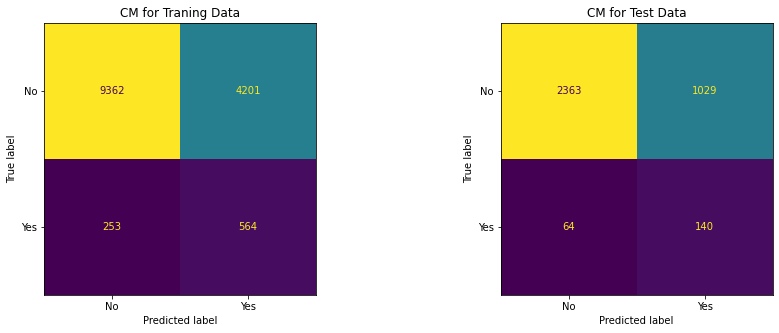

SMOTE LogisticRegression class weight: {'No': 0.3, 'Yes': 0.7}


,precision,recall,f1-score,support
No,0.985534,0.472167,0.638453,13563.000000
Yes,0.091728,0.884945,0.166226,817.000000
accuracy,0.495619,0.495619,0.495619,0.495619
macro avg,0.538631,0.678556,0.402339,14380.000000
weighted avg,0.934752,0.495619,0.611623,14380.000000
,precision,recall,f1-score,support
No,0.986776,0.461969,0.629317,3392.000000
Yes,0.091135,0.897059,0.165461,204.000000
accuracy,0.486652,0.486652,0.486652,0.486652
macro avg,0.538956,0.679514,0.397389,3596.000000


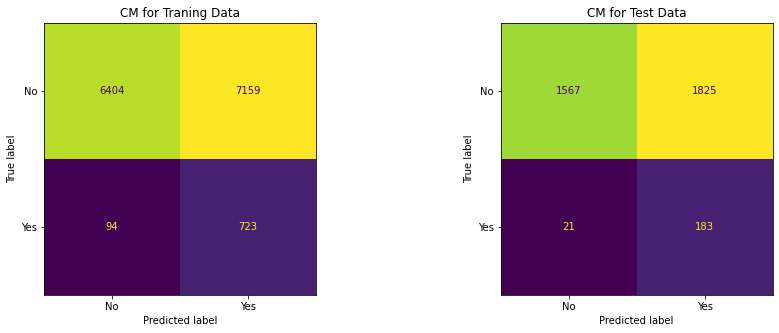

SMOTE KNeighborsClassifier class weight: None


,precision,recall,f1-score,support
No,1.000000,0.908649,0.952138,13563.000000
Yes,0.397374,1.000000,0.568743,817.000000
accuracy,0.913839,0.913839,0.913839,0.913839
macro avg,0.698687,0.954324,0.760441,14380.000000
weighted avg,0.965762,0.913839,0.930356,14380.000000
,precision,recall,f1-score,support
No,0.949251,0.821639,0.880847,3392.000000
Yes,0.083333,0.269608,0.127315,204.000000
accuracy,0.790323,0.790323,0.790323,0.790323
macro avg,0.516292,0.545623,0.504081,3596.000000


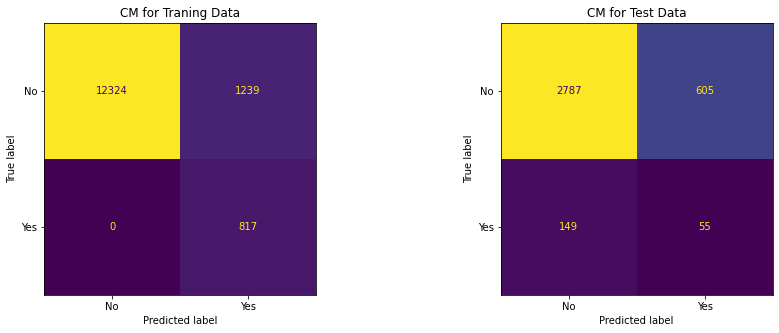

SMOTE DecisionTreeClassifier class weight: None


,precision,recall,f1-score,support
No,1.0,1.0,1.0,13563.0
Yes,1.0,1.0,1.0,817.0
accuracy,1.0,1.0,1.0,1.0
macro avg,1.0,1.0,1.0,14380.0
weighted avg,1.0,1.0,1.0,14380.0
,precision,recall,f1-score,support
No,0.946482,0.928066,0.937184,3392.000000
Yes,0.096296,0.127451,0.109705,204.000000
accuracy,0.882647,0.882647,0.882647,0.882647
macro avg,0.521389,0.527759,0.523444,3596.000000


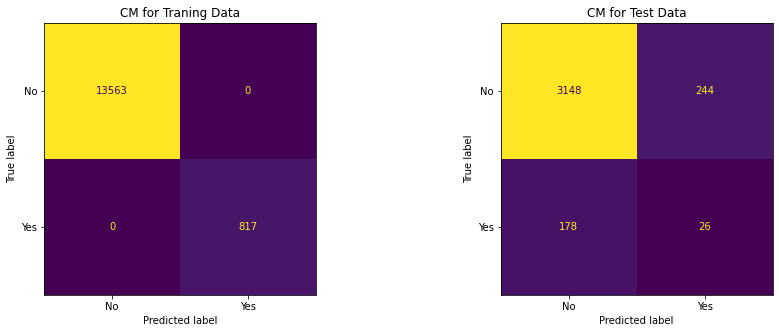

SMOTE DecisionTreeClassifier class weight: {'No': 0.3, 'Yes': 0.7}


,precision,recall,f1-score,support
No,1.0,1.0,1.0,13563.0
Yes,1.0,1.0,1.0,817.0
accuracy,1.0,1.0,1.0,1.0
macro avg,1.0,1.0,1.0,14380.0
weighted avg,1.0,1.0,1.0,14380.0
,precision,recall,f1-score,support
No,0.948141,0.932488,0.940250,3392.000000
Yes,0.119231,0.151961,0.133621,204.000000
accuracy,0.888209,0.888209,0.888209,0.888209
macro avg,0.533686,0.542224,0.536935,3596.000000


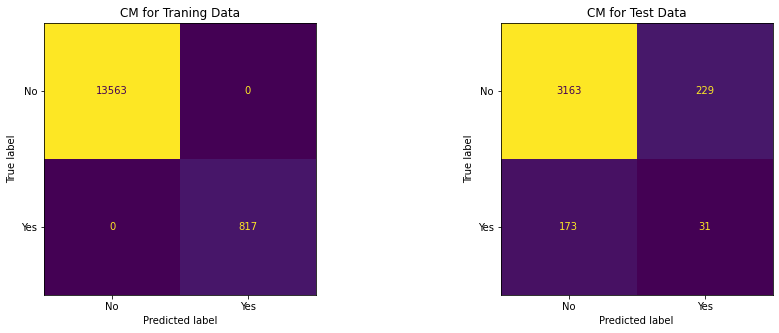

SMOTE RandomForestClassifier class weight: None


,precision,recall,f1-score,support
No,0.963880,0.838163,0.896636,13563.000000
Yes,0.151199,0.478580,0.229797,817.000000
accuracy,0.817733,0.817733,0.817733,0.817733
macro avg,0.557539,0.658371,0.563217,14380.000000
weighted avg,0.917707,0.817733,0.858750,14380.000000
,precision,recall,f1-score,support
No,0.961811,0.839033,0.896237,3392.000000
Yes,0.142857,0.446078,0.216409,204.000000
accuracy,0.816741,0.816741,0.816741,0.816741
macro avg,0.552334,0.642556,0.556323,3596.000000


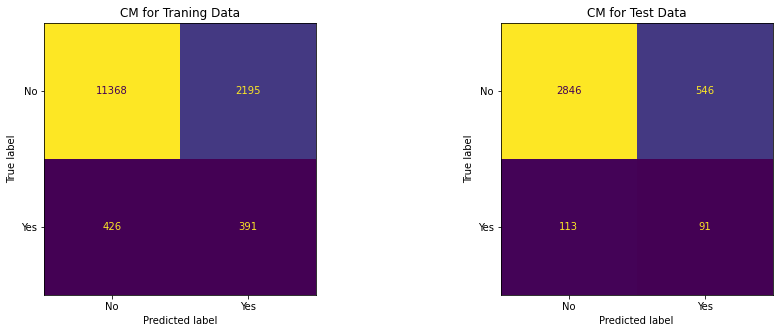

SMOTE RandomForestClassifier class weight: {'No': 0.3, 'Yes': 0.7}


,precision,recall,f1-score,support
No,0.980675,0.591167,0.737660,13563.000000
Yes,0.106222,0.806610,0.187723,817.000000
accuracy,0.603408,0.603408,0.603408,0.603408
macro avg,0.543448,0.698888,0.462691,14380.000000
weighted avg,0.930993,0.603408,0.706416,14380.000000
,precision,recall,f1-score,support
No,0.977151,0.592571,0.737750,3392.000000
Yes,0.102014,0.769608,0.180149,204.000000
accuracy,0.602614,0.602614,0.602614,0.602614
macro avg,0.539583,0.681089,0.458950,3596.000000


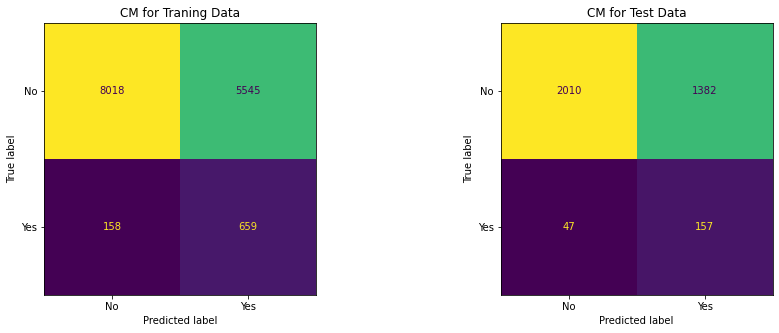

In [25]:
# define class_weight which will be passed to LogisticRegression, DecisionTreeClassifier, RandomForestClassifier
class_weight={'No': 0.3, 'Yes': 0.7}

# create a list with pipelines that are seeded with different combinations of models, 
# scaler and sampler are held constant
classification_models = [
    make_custom_pipeline(StandardScaler(), SMOTE(), \
                         LogisticRegression(random_state=42, max_iter=10000)),
    make_custom_pipeline(StandardScaler(), SMOTE(), \
                         LogisticRegression(random_state=42, max_iter=10000, class_weight=class_weight)),
    make_custom_pipeline(StandardScaler(), SMOTE(), \
                         KNeighborsClassifier(n_neighbors=3)),
    make_custom_pipeline(StandardScaler(), SMOTE(), DecisionTreeClassifier()),
    make_custom_pipeline(StandardScaler(), SMOTE(), DecisionTreeClassifier(class_weight=class_weight)),
    make_custom_pipeline(StandardScaler(), SMOTE(), RandomForestClassifier(max_depth=5, random_state=0)),
    make_custom_pipeline(StandardScaler(), SMOTE(), RandomForestClassifier(max_depth=5, random_state=0,\
                                                                           class_weight=class_weight))
]

# fit all
for pipe in classification_models:
    pipe.fit(X_train, y_train)

# predict all
for pipe in classification_models:
    y_train_pred = pipe.predict(X_train)
    y_test_pred = pipe.predict(X_test)
    handle_classification_results(y_train, y_train_pred, y_test, y_test_pred, pipe[1], pipe[2], model_comparisson)

RandomUnderSampler LogisticRegression class weight: None


,precision,recall,f1-score,support
No,0.974343,0.674777,0.797351,13563.000000
Yes,0.115500,0.705018,0.198484,817.000000
accuracy,0.676495,0.676495,0.676495,0.676495
macro avg,0.544921,0.689898,0.497918,14380.000000
weighted avg,0.925547,0.676495,0.763327,14380.000000
,precision,recall,f1-score,support
No,0.975351,0.676592,0.798956,3392.00000
Yes,0.117458,0.715686,0.201797,204.00000
accuracy,0.678810,0.678810,0.678810,0.67881
macro avg,0.546404,0.696139,0.500376,3596.00000


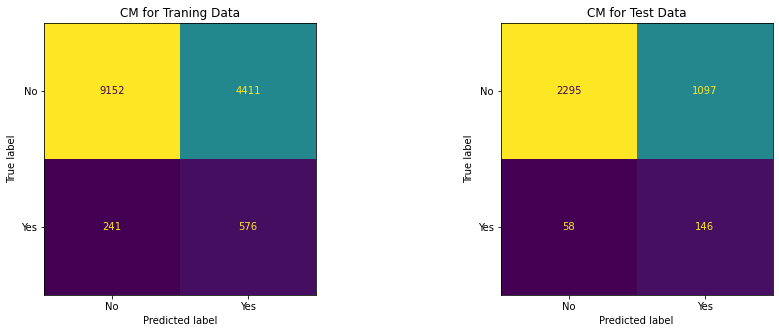

RandomUnderSampler LogisticRegression class weight: {'No': 0.3, 'Yes': 0.7}


,precision,recall,f1-score,support
No,0.988002,0.400723,0.570185,13563.000000
Yes,0.084582,0.919217,0.154909,817.000000
accuracy,0.430181,0.430181,0.430181,0.430181
macro avg,0.536292,0.659970,0.362547,14380.000000
weighted avg,0.936674,0.430181,0.546591,14380.000000
,precision,recall,f1-score,support
No,0.988688,0.386498,0.555744,3392.00000
Yes,0.083260,0.926471,0.152789,204.00000
accuracy,0.417130,0.417130,0.417130,0.41713
macro avg,0.535974,0.656484,0.354266,3596.00000


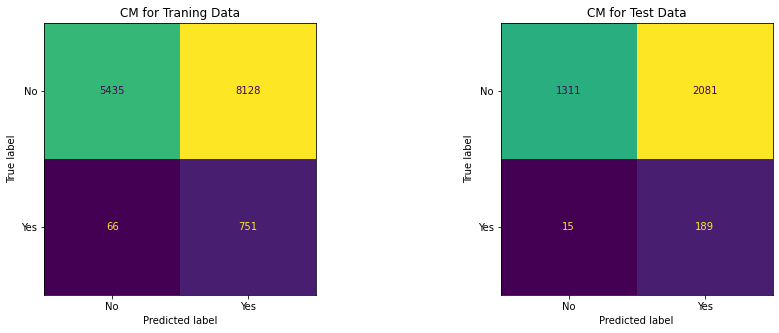

RandomUnderSampler KNeighborsClassifier class weight: None


,precision,recall,f1-score,support
No,0.984720,0.574947,0.726003,13563.000000
Yes,0.107723,0.851897,0.191261,817.000000
accuracy,0.590682,0.590682,0.590682,0.590682
macro avg,0.546222,0.713422,0.458632,14380.000000
weighted avg,0.934894,0.590682,0.695622,14380.000000
,precision,recall,f1-score,support
No,0.963923,0.559257,0.707836,3392.000000
Yes,0.081695,0.651961,0.145197,204.000000
accuracy,0.564516,0.564516,0.564516,0.564516
macro avg,0.522809,0.605609,0.426516,3596.000000


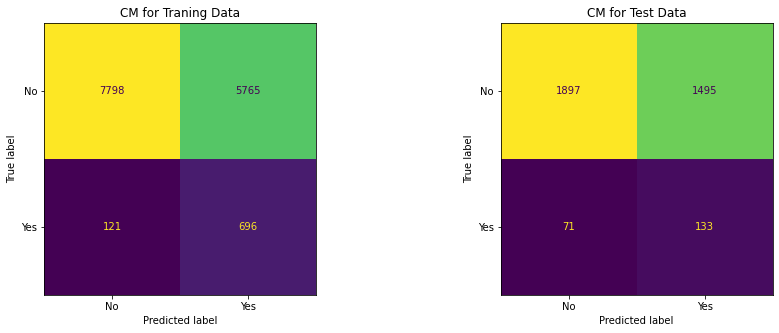

RandomUnderSampler DecisionTreeClassifier class weight: None


,precision,recall,f1-score,support
No,1.000000,0.606061,0.754717,13563.000000
Yes,0.132630,1.000000,0.234198,817.000000
accuracy,0.628442,0.628442,0.628442,0.628442
macro avg,0.566315,0.803030,0.494458,14380.000000
weighted avg,0.950720,0.628442,0.725144,14380.000000
,precision,recall,f1-score,support
No,0.963438,0.598172,0.738087,3392.000000
Yes,0.085235,0.622549,0.149941,204.000000
accuracy,0.599555,0.599555,0.599555,0.599555
macro avg,0.524336,0.610361,0.444014,3596.000000


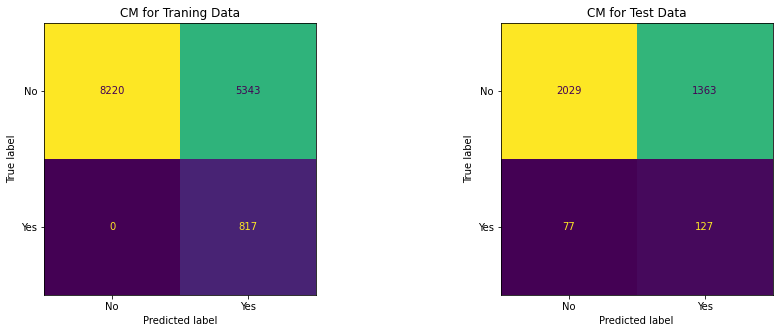

RandomUnderSampler DecisionTreeClassifier class weight: {'No': 0.3, 'Yes': 0.7}


,precision,recall,f1-score,support
No,1.000000,0.634152,0.776123,13563.000000
Yes,0.141374,1.000000,0.247726,817.000000
accuracy,0.654937,0.654937,0.654937,0.654937
macro avg,0.570687,0.817076,0.511925,14380.000000
weighted avg,0.951217,0.654937,0.746103,14380.000000
,precision,recall,f1-score,support
No,0.952226,0.605248,0.740087,3392.000000
Yes,0.070139,0.495098,0.122871,204.000000
accuracy,0.598999,0.598999,0.598999,0.598999
macro avg,0.511183,0.550173,0.431479,3596.000000


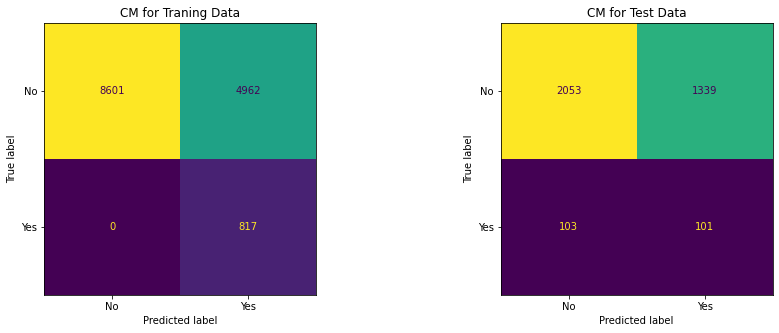

RandomUnderSampler RandomForestClassifier class weight: None


,precision,recall,f1-score,support
No,0.982614,0.637543,0.773331,13563.000000
Yes,0.118996,0.812729,0.207597,817.000000
accuracy,0.647497,0.647497,0.647497,0.647497
macro avg,0.550805,0.725136,0.490464,14380.000000
weighted avg,0.933547,0.647497,0.741189,14380.000000
,precision,recall,f1-score,support
No,0.975719,0.639741,0.772792,3392.000000
Yes,0.109329,0.735294,0.190355,204.000000
accuracy,0.645161,0.645161,0.645161,0.645161
macro avg,0.542524,0.687517,0.481574,3596.000000


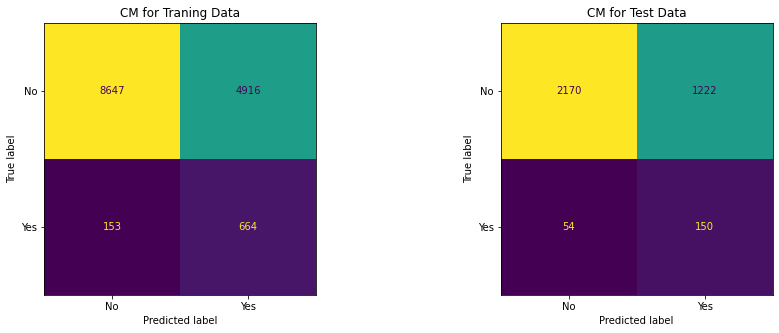

RandomUnderSampler RandomForestClassifier class weight: {'No': 0.3, 'Yes': 0.7}


,precision,recall,f1-score,support
No,0.995284,0.280100,0.437169,13563.00000
Yes,0.075641,0.977968,0.140422,817.00000
accuracy,0.319750,0.319750,0.319750,0.31975
macro avg,0.535463,0.629034,0.288795,14380.00000
weighted avg,0.943035,0.319750,0.420309,14380.00000
,precision,recall,f1-score,support
No,0.991351,0.270342,0.424832,3392.000000
Yes,0.073381,0.960784,0.136348,204.000000
accuracy,0.309511,0.309511,0.309511,0.309511
macro avg,0.532366,0.615563,0.280590,3596.000000


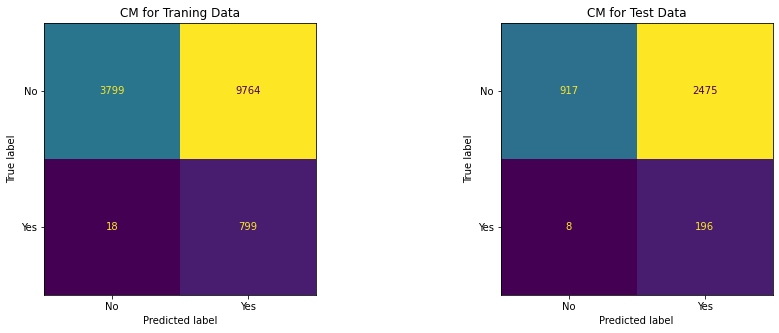

In [26]:
# define class_weight which will be passed to LogisticRegression, DecisionTreeClassifier, RandomForestClassifier
class_weight={'No': 0.3, 'Yes': 0.7}

# create a list with pipelines that are seeded with different combinations of models, 
# scaler and sampler are held constant
classification_models_rus = [
    make_custom_pipeline(StandardScaler(), RandomUnderSampler(), \
                         LogisticRegression(random_state=42, max_iter=10000)),
    make_custom_pipeline(StandardScaler(), RandomUnderSampler(), \
                         LogisticRegression(random_state=42, max_iter=10000, class_weight=class_weight)),
    make_custom_pipeline(StandardScaler(), RandomUnderSampler(), \
                         KNeighborsClassifier(n_neighbors=3)),
    make_custom_pipeline(StandardScaler(), RandomUnderSampler(), DecisionTreeClassifier()),
    make_custom_pipeline(StandardScaler(), RandomUnderSampler(), DecisionTreeClassifier(class_weight=class_weight)),
    make_custom_pipeline(StandardScaler(), RandomUnderSampler(), RandomForestClassifier(max_depth=5, \
                                                                                        random_state=0)),
    make_custom_pipeline(StandardScaler(), RandomUnderSampler(), RandomForestClassifier(max_depth=5,\
                                                                                        random_state=0,\
                                                                           class_weight=class_weight))
]

for pipe in classification_models_rus:
    pipe.fit(X_train, y_train)

# predict
for pipe in classification_models_rus:
    y_train_pred = pipe.predict(X_train)
    y_test_pred = pipe.predict(X_test)

    handle_classification_results(y_train, y_train_pred, y_test, y_test_pred, pipe[1], pipe[2], model_comparisson)

In [27]:
# shows results from all model runs as an overview
model_comparisson

,model,sampler,class_weight,f1_score,yes_f1,yes_precision,yes_recall,no_f1,no_precision,no_recall
0,LogisticRegression,SMOTE,None,0.696051,0.203933,0.119760,0.686275,0.812167,0.973630,0.696639
1,LogisticRegression,SMOTE,"{'No': 0.3, 'Yes': 0.7}",0.486652,0.165461,0.091135,0.897059,0.629317,0.986776,0.461969
2,KNeighborsClassifier,SMOTE,None,0.790323,0.127315,0.083333,0.269608,0.880847,0.949251,0.821639
3,DecisionTreeClassifier,SMOTE,None,0.882647,0.109705,0.096296,0.127451,0.937184,0.946482,0.928066
4,DecisionTreeClassifier,SMOTE,"{'No': 0.3, 'Yes': 0.7}",0.888209,0.133621,0.119231,0.151961,0.940250,0.948141,0.932488
5,RandomForestClassifier,SMOTE,None,0.816741,0.216409,0.142857,0.446078,0.896237,0.961811,0.839033
6,RandomForestClassifier,SMOTE,"{'No': 0.3, 'Yes': 0.7}",0.602614,0.180149,0.102014,0.769608,0.737750,0.977151,0.592571
7,LogisticRegression,RandomUnderSampler,None,0.678810,0.201797,0.117458,0.715686,0.798956,0.975351,0.676592
8,LogisticRegression,RandomUnderSampler,"{'No': 0.3, 'Yes': 0.7}",0.417130,0.152789,0.083260,0.926471,0.555744,0.988688,0.386498
9,KNeighborsClassifier,RandomUnderSampler,None,0.564516,0.145197,0.081695,0.651961,0.707836,0.963923,0.559257


In [28]:
# order all model runs by recall for positive class
model_comparisson.sort_values(by=['yes_recall'], ascending=False).head(4)

,model,sampler,class_weight,f1_score,yes_f1,yes_precision,yes_recall,no_f1,no_precision,no_recall
13,RandomForestClassifier,RandomUnderSampler,"{'No': 0.3, 'Yes': 0.7}",0.309511,0.136348,0.073381,0.960784,0.424832,0.991351,0.270342
8,LogisticRegression,RandomUnderSampler,"{'No': 0.3, 'Yes': 0.7}",0.417130,0.152789,0.083260,0.926471,0.555744,0.988688,0.386498
1,LogisticRegression,SMOTE,"{'No': 0.3, 'Yes': 0.7}",0.486652,0.165461,0.091135,0.897059,0.629317,0.986776,0.461969
6,RandomForestClassifier,SMOTE,"{'No': 0.3, 'Yes': 0.7}",0.602614,0.180149,0.102014,0.769608,0.737750,0.977151,0.592571


## Conclusion

- precise classification based on the given dataset of bank customers proves quite difficult. As can be seen from the model coparisson summary a good precision for simultaniously both classes 'YES' and 'NO' could not be achieved.

- since we assume that the costs of predicting FP is smaller then the potentially foregone profit from TN we would highly recommend to select the model which optimized recall for 'YES'. Based on our analysis this would be the combination of 'RandomForestClassifier' with 'RandomUnderSampler' and a custom configuration for the class weights. 
- please be aware that this is a recommendation based on the comparisson between the limited amount of models we selected for this project. 